In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import torch
import hdbscan

from utils import parse_result_line, drop_correlated_features, drop_skewed_features, aggregate_columns, plot_cluster_averages
from aencoder import Autoencoder, train_autoencoder

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
# Read all files and parse aencoder results
results_dir = "/Users/leo/Programming/PLR/Leo/main/final/grid_results"
result_files = [f for f in os.listdir(results_dir) if f.startswith('aencoder_grid') and f.endswith('.txt')]

all_results = []
for file in result_files:
    dataset_number = int(re.search(r'_([1-5])\.txt$', file).group(1))  # Extract dataset number from file name
    with open(os.path.join(results_dir, file), 'r') as f:
        for line in f:
            parsed_line = parse_result_line(line, dataset_number)
            if parsed_line:
                all_results.append(parsed_line)

# Filter and sort results
filtered_results = [res for res in all_results if res['num_clusters'] <= 13]
top_results = sorted(filtered_results, key=lambda x: x['silhouette_score'], reverse=True)[:10]

In [3]:
result_files

['aencoder_grid_2.txt',
 'aencoder_grid_3.txt',
 'aencoder_grid_1.txt',
 'aencoder_grid_4.txt',
 'aencoder_grid_5.txt']

In [4]:
all_results

[{'silhouette_score': -0.0121,
  'num_clusters': 6,
  'skew_threshold': 0.75,
  'corr_threshold': 0.5,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.001,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 10},
  'dataset': 2},
 {'silhouette_score': -1.0,
  'num_clusters': 3,
  'skew_threshold': 0.75,
  'corr_threshold': 0.5,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.001,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 15},
  'dataset': 2},
 {'silhouette_score': -1.0,
  'num_clusters': 4,
  'skew_threshold': 0.75,
  'corr_threshold': 0.5,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.001,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 25},
  'dataset': 2},
 {'silhouette_score': -1.0,
  'num_clusters': 34,
  'skew_threshold': 0.75,
  'corr_threshold': 0.5,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.001,
  'epochs': 500,
  'hdbscan_params': {

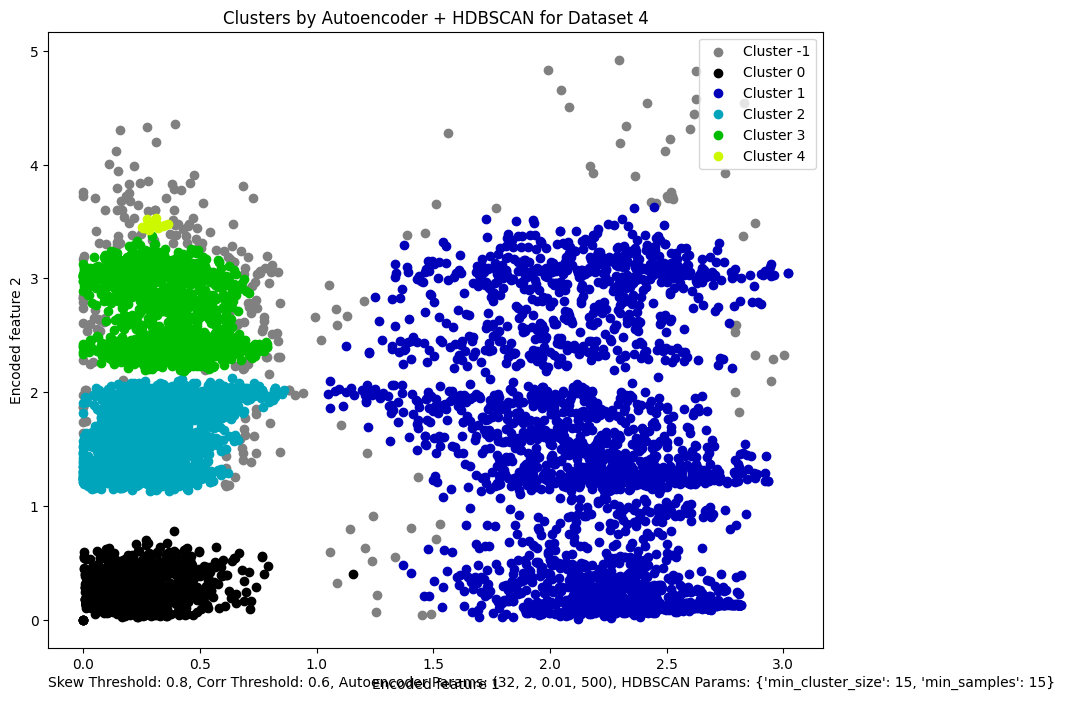

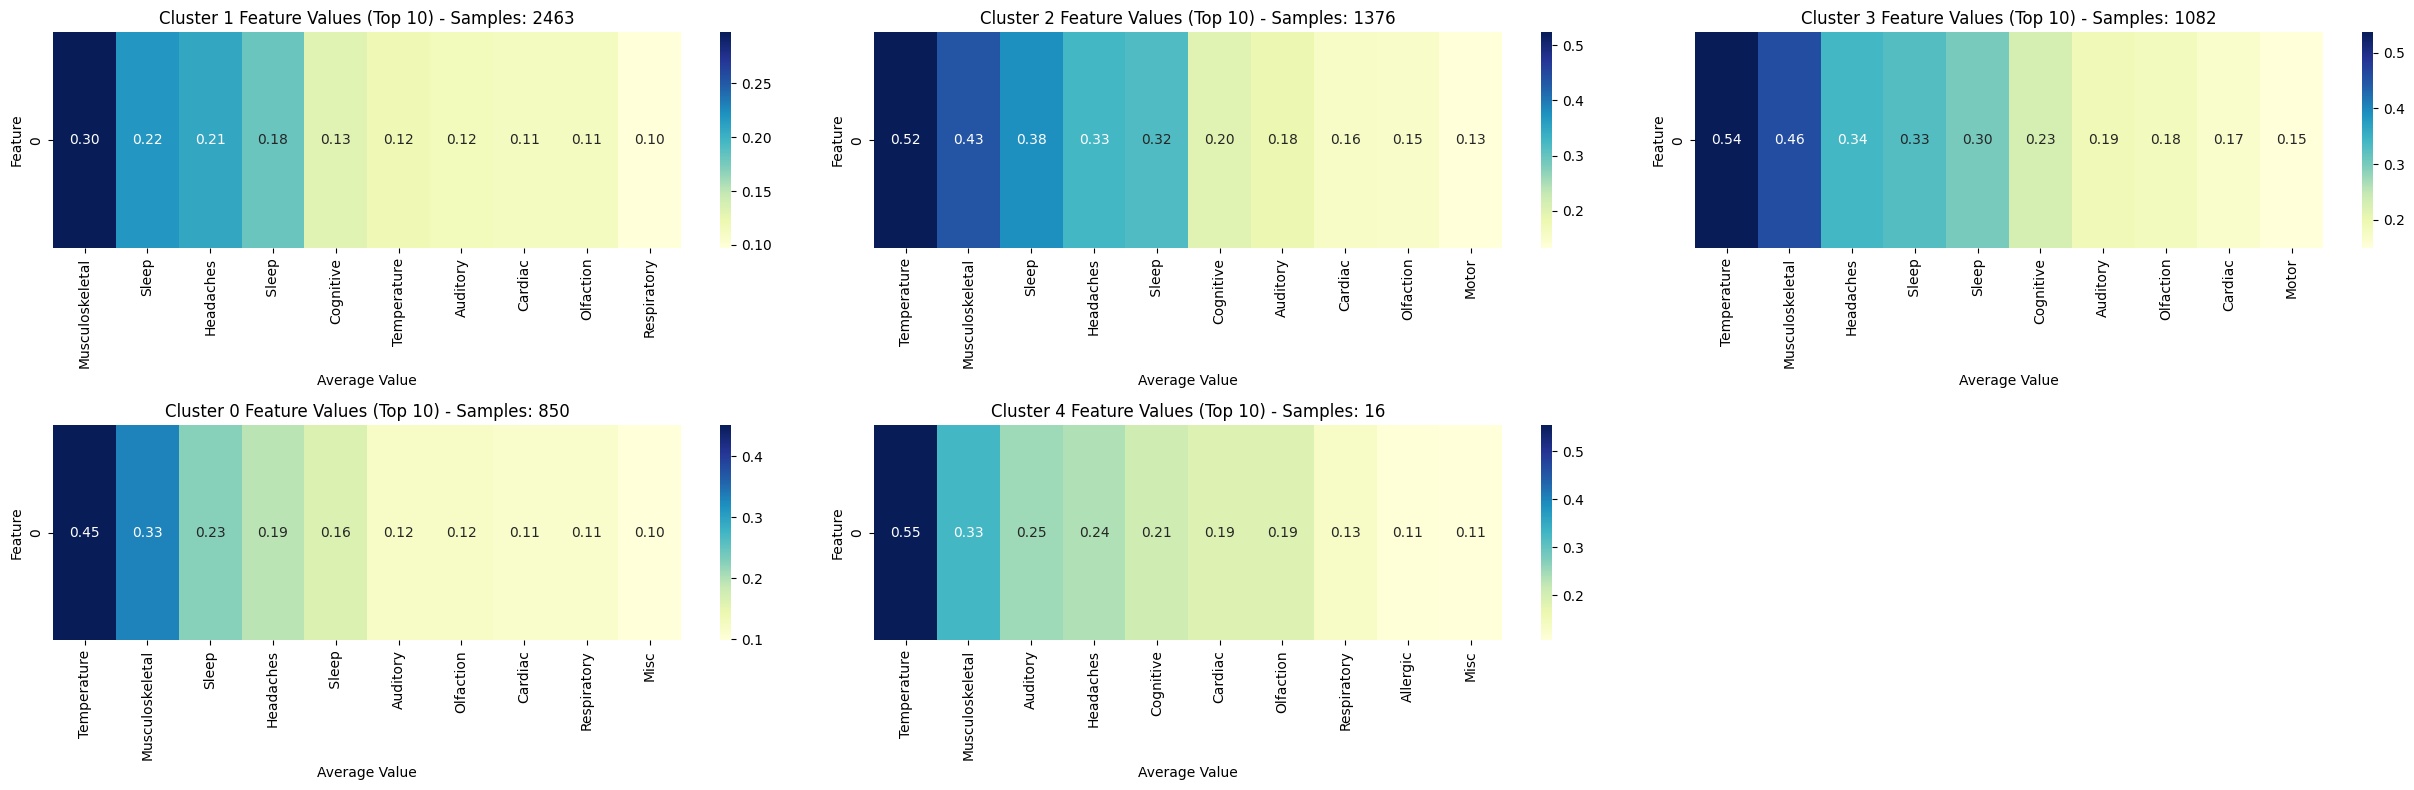

In [5]:
# Main processing and visualization loop for Autoencoder
for result in top_results:
    # Load dataset
    dataset_path = f"/Users/leo/Programming/PLR/Leo/data/dataset_{result['dataset']}.csv"
    data = pd.read_csv(dataset_path).drop(columns=["Unnamed: 0"])

    # Preprocess data
    data_unskewed = drop_skewed_features(data, result['skew_threshold'])
    data_drop_corr = drop_correlated_features(data_unskewed, result['corr_threshold'])

    # Convert data to PyTorch tensors
    tensor_data = torch.tensor(data_drop_corr.values, dtype=torch.float32)

    # Initialize and train Autoencoder
    autoencoder_model = Autoencoder(input_size=tensor_data.shape[1], hidden_size=result['hidden_size'], latent_dim=result['latent_dim'])
    trained_model = train_autoencoder(autoencoder_model, tensor_data, result['learning_rate'], result['epochs'])

    # Apply Autoencoder
    data_encoded = trained_model.encoder(tensor_data).detach().numpy()

    # Apply HDBSCAN
    clusterer = hdbscan.HDBSCAN(**result['hdbscan_params'])
    cluster_labels = clusterer.fit_predict(data_encoded)

    # Visualize the clusters with parameters annotation
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        color = 'grey' if label == -1 else plt.cm.nipy_spectral(float(label) / len(unique_labels))
        plt.scatter(data_encoded[cluster_labels == label, 0], data_encoded[cluster_labels == label, 1], c=[color], label=f'Cluster {label}')

    plt.title(f'Clusters by Autoencoder + HDBSCAN for Dataset {result["dataset"]}')
    plt.xlabel('Encoded feature 1')
    plt.ylabel('Encoded feature 2')
    plt.legend()

    params_text = f"Skew Threshold: {result['skew_threshold']}, Corr Threshold: {result['corr_threshold']}, Autoencoder Params: {result['hidden_size'], result['latent_dim'], result['learning_rate'], result['epochs']}, HDBSCAN Params: {result['hdbscan_params']}"
    plt.annotate(params_text, (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    plt.show()

    # Save cluster labels
    data_drop_corr['cluster'] = cluster_labels
    data_drop_corr.to_csv(f"optimized_dataset_{result['dataset']}_clusters.csv", index=False)

    # Load and process symptom groupings
    groupings_path = '/Users/leo/Programming/PLR/Leo/data/symptom_groups.csv'
    symptom_groups = pd.read_csv(groupings_path)
    group_dict = dict(zip(symptom_groups['symptom'], symptom_groups['group']))
    dataset_aggregated = aggregate_columns(data_drop_corr, group_dict)

    # Plot the cluster averages
    plot_cluster_averages(dataset_aggregated, data_drop_corr['cluster'])

    print("\n" + "=" * 160 + "\n")
